## *Analyzing StatsBomb Shot Freeze Frames and Constructing an xG Model*
    - Retrieve details regarding shots and their attributes.
    - Investigate the use and information extracted from shot freeze frames.
    - Extract new features.
    - Develop a predictive model for expected goals.
    - Evaluate the performance and accuracy of the created model.

In [10]:
import os
import json
import pandas as pd
import numpy as np
import math 
import matplotlib.pyplot as plt 
from mplsoccer import Pitch
import geopandas as gpd 
from shapely.geometry import MultiPoint, Polygon, Point 

In [11]:
match_events_path= 'data/events/7451.json'
with open(match_events_path, 'r') as file:
    data = json.load(file)
df = pd.json_normalize(data)

# Keep shots rows 
shots_df= df.loc[df['shot.freeze_frame'].notnull()]
shots_df[['X','Y']] = shots_df['location'].apply(lambda x: pd.Series(x, index=['X', 'Y']))

# An example
shot_freeze_frames = shots_df['shot.freeze_frame']
shot_freeze_frames.iloc[5]

/tmp/ipykernel_5088/533004324.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shots_df[['X','Y']] = shots_df['location'].apply(lambda x: pd.Series(x, index=['X', 'Y']))
/tmp/ipykernel_5088/533004324.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shots_df[['X','Y']] = shots_df['location'].apply(lambda x: pd.Series(x, index=['X', 'Y']))


[{'location': [102.0, 60.0],
  'player': {'id': 5034, 'name': 'Jessica McDonald'},
  'position': {'id': 24, 'name': 'Left Center Forward'},
  'teammate': True},
 {'location': [118.0, 38.0],
  'player': {'id': 5025, 'name': 'Aubrey Renee Kingsbury'},
  'position': {'id': 1, 'name': 'Goalkeeper'},
  'teammate': False},
 {'location': [104.0, 49.0],
  'player': {'id': 5088, 'name': 'Crystal Alyssia Dunn Soubrier'},
  'position': {'id': 22, 'name': 'Right Center Forward'},
  'teammate': True},
 {'location': [102.0, 53.0],
  'player': {'id': 4962, 'name': 'Caprice Dydasco'},
  'position': {'id': 6, 'name': 'Left Back'},
  'teammate': False},
 {'location': [102.0, 44.0],
  'player': {'id': 4950, 'name': 'Whitney Church'},
  'position': {'id': 5, 'name': 'Left Center Back'},
  'teammate': False},
 {'location': [99.0, 44.0],
  'player': {'id': 5029, 'name': 'Tori Huster'},
  'position': {'id': 10, 'name': 'Center Defensive Midfield'},
  'teammate': False},
 {'location': [102.0, 37.0],
  'player

In [17]:
events_id= list(shots_df.id)
shot_frames= list(shots_df['shot.freeze_frame'])
rows=[]
for event_id, frame in zip(events_id, shot_frames):
    for i in frame:
        rows.append((event_id, i['location'][0], i['location'][1], i['position']['name'],i['teammate']))
df_shot_frame= pd.DataFrame(data= rows, columns=["id", "x", "y", "position", "teammate"])
        
statsbomb_pitch = Pitch()
vertices = np.zeros((len(df_shot_frame), 3, 2))
vertices[:, 1:, :] = statsbomb_pitch.goal_right
vertices[:, 0, :] = df_shot_frame[['x','y']].values
vertices = gpd.GeoSeries([Polygon(vert) for vert in vertices])
vertices = gpd.GeoDataFrame({'id': df_shot_frame['id'], 'shot_polygon': gpd.GeoSeries(vertices)})

player_positions = gpd.GeoSeries.from_xy(df_shot_frame['x'], df_shot_frame['y'])
player_positions = gpd.GeoDataFrame({'id': df_shot_frame['id'], 'position': player_positions,
                                    'Tactical position':df_shot_frame["position"], 'teammate':df_shot_frame["teammate"]})

player_positions = gpd.GeoDataFrame(player_positions.merge(vertices, on='id'))

# add a mask for whether the player intersects with the goal angle
player_positions['does player interfer with the goal angle'] = player_positions['position'].intersects(player_positions['shot_polygon'])

In [23]:
player_positions.head()

,id,position,Tactical position,teammate,shot_polygon,does player interfer with the goal angle
0,9848d3a6-448d-4b9c-8743-2d519857f24d,POINT (115.00000 42.00000),Goalkeeper,False,"POLYGON ((115.00000 42.00000, 120.00000 44.000...",True
1,9848d3a6-448d-4b9c-8743-2d519857f24d,POINT (115.00000 42.00000),Goalkeeper,False,"POLYGON ((112.00000 49.00000, 120.00000 44.000...",False
2,9848d3a6-448d-4b9c-8743-2d519857f24d,POINT (115.00000 42.00000),Goalkeeper,False,"POLYGON ((110.00000 36.00000, 120.00000 44.000...",False
3,9848d3a6-448d-4b9c-8743-2d519857f24d,POINT (115.00000 42.00000),Goalkeeper,False,"POLYGON ((112.00000 41.00000, 120.00000 44.000...",True
4,9848d3a6-448d-4b9c-8743-2d519857f24d,POINT (115.00000 42.00000),Goalkeeper,False,"POLYGON ((113.00000 37.00000, 120.00000 44.000...",False


In [14]:
# Now we drop player who doesn't interefer with the shot angle
player_positions= player_positions[player_positions['does player interfer with the goal angle']]

# Now let's sum all angles that are occupied by non-shooter players for each shot


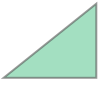

In [36]:
player_positions.shot_polygon[7]

## *Data Pre-processing*

In [2]:
def process_json_file(file_path, shots_list):
    with open(file_path, 'r') as file:
        data = json.load(file)
        for item in data:
            shot = item.get('shot')
            location = item.get('location')
            if shot is not None:
                shots_list.append((shot, location))

In [3]:
def process_all_json_files_in_directory(directory):
    shots_list = []
    
    for filename in os.listdir(directory):
        if filename.endswith('.json'):
            file_path = os.path.join(directory, filename)
            process_json_file(file_path, shots_list)
    
    return shots_list

In [4]:
json_directory = 'data/events'
shots = process_all_json_files_in_directory(json_directory)
# Create a DataFrame out of proceesed data
df = pd.DataFrame(shots, columns=['Shot Value', 'Location'])
df